# Example 2D stitching workflow

This notebook demonstrates a workflow for stitching (potentially large) 2D data available as tif stacks or OME-Zarr files.

*The workflow is essentially the same as the one in stitching_bigstitcher_grid_3d_ngff.ipynb, but adapted to 2D data. The main difference is that specified metadata is adapted, e.g. `scale = {'z': 2, 'y': 0.5, 'x': 0.5}` becomes `scale = {'y': 0.5, 'x': 0.5}`. Also, as opposed to the 3D example the tiff files here contain several channels, exemplifying how input file handling can be done this case.*

#### 1) Download the example dataset

This notebook uses [this example dataset](https://drive.google.com/file/d/15xSQCBHcpEvJWd6YD5iKJzuc0IRpWB8a/view?usp=sharing) provided by [BigStitcher](https://github.com/JaneliaSciComp/BigStitcher-Spark?tab=readme-ov-file#examples) (6 tiles, 3 channels). The dataset is in 3D and for this example we'll project it to 2D.

#### 2) Convert input tif files into [OME-Zarr files](https://www.nature.com/articles/s41592-021-01326-w)

This is useful in two ways:

1) Image data cannot (easily) be read from tif files in a lazy and chunked manner. However, this is necessary when working with large images that shouldn't be loaded all at once. OME-Zarr files can be read chunkwise and will allow the stitching workflow to keep a low memory footprint and optimize its parallelism.

2) OME-Zarr standardises metadata. In particular, this includes (positional) scale and translation metadata for each input tile. In the context of a stitching workflow, this can help with
    - setting initial tile positions
    - storing registered tile positions next to the unfused input data

This notebook makes use of user input to place the input tiles (regular tif stacks) on a regular grid to serve as a starting point for registration. This positional metadata is saved in the OME-Zarr files. Alternatively, OME-Zarr files that already contain positional metadata can be used as an input to the stitching workflow.

#### 3) Perform channel alignment (optional)

In case the input data exhibits shifts between the input channels, a tile can be selected that is used for performing a (translational) channel registration.

#### 4) Tile registration

The tiles are registered using one of the input channels. The obtained transform parameters can be read out.

#### 5) Fuse the tiles into a single output image

The registered tiles are combined (fused) into a single output image. Weighted averaging is used to smoothly blend the tiles at the tile boundaries by using pixel-wise weights that decrease in proximity to the tile boundaries.

The fused image is saved in OME-Zarr format and can be streamed into a tif stack.

### Visualization

This notebook uses two tools for visualization:
- neuroglancer (no installation required)
- napari (requires installing `napari-stitcher` separately)

In [1]:
import os
import zipfile
import xarray as xr
from pathlib import Path

import dask.diagnostics
import ngff_zarr
import numpy as np
import dask.array as da
import tifffile
from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import (
    fusion,
    io,
    msi_utils,
    vis_utils,
    ngff_utils,
    param_utils,
    registration,
)
from tqdm import tqdm

## Download the example dataset

We're using [this](https://drive.google.com/file/d/15xSQCBHcpEvJWd6YD5iKJzuc0IRpWB8a/view?usp=sharing) example dataset provided by [BigStitcher](https://github.com/JaneliaSciComp/BigStitcher-Spark?tab=readme-ov-file#examples): https://github.com/JaneliaSciComp/BigStitcher-Spark?tab=readme-ov-file#examples. It contains 6 tiles and 3 channels. The dataset is in 3D and for this example we'll project it to 2D.

For downloading it from google drive, we'll use the `gdown` package.

In [2]:
# install gdown if not already installed
!pip install gdown

# download the data from google drive, which will be available as a zip file "Stitching_TIFF.zip"

download_zip_path = Path("Stitching_TIFF.zip")
download_path = Path(download_zip_path.stem)

if not os.path.exists(download_zip_path):
    import os
    os.system('gdown 15xSQCBHcpEvJWd6YD5iKJzuc0IRpWB8a') # this is the google drive id of the file
else:
    print("File already downloaded")

# unzip and project the 3D images to 2D

import zipfile
with zipfile.ZipFile(download_zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_path)

# project 3D images to 2D for this example
tif_files_3d = list(Path(download_path).glob('7*.tif'))
tif_files_2d = [p.with_name("MAX_" + p.name) for p in tif_files_3d]
for i in tqdm(range(len(tif_files_3d)), desc="Projecting 3D images to 2D"):
    im = tifffile.imread(tif_files_3d[i])
    im = np.max(im, axis=0)
    tifffile.imwrite(tif_files_2d[i], im)
del im

print('Files in the directory:\n', '\n'.join([str(path.name) for path in tif_files_2d]))

File already downloaded


Projecting 3D images to 2D: 100%|██████████| 6/6 [00:00<00:00, 68.00it/s]

Files in the directory:
 MAX_73.tif
MAX_76.tif
MAX_77.tif
MAX_75.tif
MAX_74.tif
MAX_78.tif


## Specify input files

In [3]:
# indicate the tiles and channels to process
tiles = range(73, 79)

def get_filename_from_tile_and_channel(tile):
    """
    This convenience function returns the filename given the tile and channel.
    """
    return download_path / f'MAX_{tile}.tif'

print('Example filename:\n', get_filename_from_tile_and_channel(tiles[0]))

Example filename:
 Stitching_TIFF/MAX_73.tif


## Read input data and convert to OME-Zarr

This includes (pre-)arranging the tiles on a grid.

Note that here we assum 
This way of setting the initial tile positions is specific to the example data and can easily be adapted / replaced. What matters at the end are the values passed for `scale` and `translation` to `si_utils.get_sim_from_array` for each tile.

You can use "visualize tile positions/configuration" further down to check the resulting tile arrangement.



### Arranging the tiles on the grid

Assuming that tiles are positioned on a regular grid, in the cell below we specify each tile's position on the grid.

If tiles are not positioned on a regular grid, you can skip this step and provide the positional metadata in a cell further down.

In [4]:
# indicate how the tile index maps onto the grid position for each tile index
# (as a function of the tile index)
# examples:
#  get_tile_grid_position_from_tile_index(0) -> {'z': 0, 'y': 0, 'x': 0}
#  get_tile_grid_position_from_tile_index(1) -> {'z': 0, 'y': 0, 'x': 1}
#  get_tile_grid_position_from_tile_index(2) -> {'z': 0, 'y': 1, 'x': 0}
#  etc.
def get_tile_grid_position_from_tile_index(tile_index):
    num_xy_columns = 2
    return {
        'z': 0, # all tiles are on the same z position
        'y': tile_index // num_xy_columns, # new y position every 2 tiles
        'x': tile_index % num_xy_columns, # reset x position every 2 tiles
    }

print("Tile grid indices:")
print("\n".join([f"Tile {itile}: " + str(get_tile_grid_position_from_tile_index(itile))
    for itile, tile in enumerate(tiles)]))

Tile grid indices:
Tile 0: {'z': 0, 'y': 0, 'x': 0}
Tile 1: {'z': 0, 'y': 0, 'x': 1}
Tile 2: {'z': 0, 'y': 1, 'x': 0}
Tile 3: {'z': 0, 'y': 1, 'x': 1}
Tile 4: {'z': 0, 'y': 2, 'x': 0}
Tile 5: {'z': 0, 'y': 2, 'x': 1}


### Specifying image metadata

In [5]:
# indicate input pixel spacing
# scale = {'z': 5, 'y': 1, 'x': 1}
scale = {'y': .1, 'x': .1}

# indicate approximate overlap between tiles relative to the image shape
overlap = {
    'y': 0.1, # 10% overlap in between rows
    'x': 0.15 # 15% overlap in between columns
    }

# get image data shape from the first tile (without channel dim, i.e. in (z)yx)
# (this line can be replaced by e.g.: `tile_shape = {'z': 100, 'y': 1000, 'x': 1000}`)
tile_shape = {
    dim: s for dim, s in zip(
        ['y', 'x'],
        tifffile.imread(get_filename_from_tile_and_channel(tiles[0])).shape[1:]
    )
}
print("Tile shape: ", tile_shape)


Tile shape:  {'y': 512, 'x': 512}


### Calculating the tile positions in physical units

Tile positions:
Tile 0: {'y': 0.0, 'x': 0.0}
Tile 1: {'y': 0.0, 'x': 43.52}
Tile 2: {'y': 46.080000000000005, 'x': 0.0}
Tile 3: {'y': 46.080000000000005, 'x': 43.52}
Tile 4: {'y': 92.16000000000001, 'x': 0.0}
Tile 5: {'y': 92.16000000000001, 'x': 43.52}


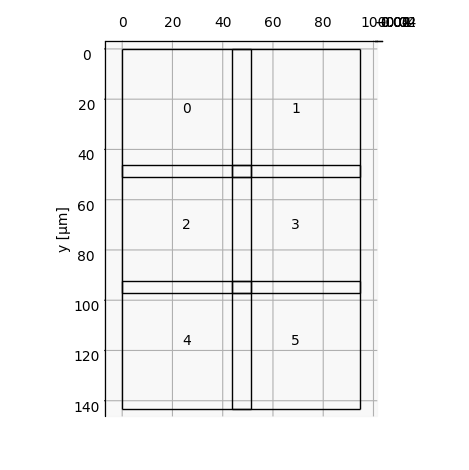

(<Figure size 640x480 with 1 Axes>, <Axes3D: ylabel='x [μm]', zlabel='y [μm]'>)

In [6]:
translations = []
for itile, tile in enumerate(tiles):
    tile_grid_position = get_tile_grid_position_from_tile_index(itile)
    translations.append(
        {
            dim: tile_grid_position[dim] * (1 - (overlap[dim] if dim in overlap else 1)) * tile_shape[dim] * scale[dim]
            for dim in scale
        }
    )

print("Tile positions:")
print("\n".join([f"Tile {itile}: " + str(t) for itile, t in enumerate(translations)]))

# visualize the tile positions
# uncomment the following line to have an interactive 3D visualization (requires `ipympl` to be installed)
# %matplotlib ipympl
vis_utils.plot_positions(
    [msi_utils.get_msim_from_sim(si_utils.get_sim_from_array(
        da.zeros([tile_shape[dim] for dim in scale]), dims=list(scale.keys()), scale=scale, translation=translations[i]))
        for i in range(len(tiles))],
    use_positional_colors=False,
    transform_key=io.METADATA_TRANSFORM_KEY,
)

### Save as OME-Zarr

In [7]:
# Read input tiles and convert to OME-Zarr files
overwrite = True

msims = []
zarr_paths = []
for itile, tile in tqdm(enumerate(tiles[:])):

    # where to save the zarr(s)
    zarr_path = os.path.join(os.path.dirname(get_filename_from_tile_and_channel(tile)),
                             f'tile_{tile:02d}.zarr')

    # read tile image
    if os.path.exists(zarr_path) and not overwrite:
        im_data = da.from_zarr(os.path.join(zarr_path, '0'))[0] # drop t axis automatically added
    else:
        im_data = tifffile.imread(get_filename_from_tile_and_channel(tile))

    sim = si_utils.get_sim_from_array(
        im_data,
        dims=["c"] + list(scale.keys()),
        scale=scale,
        translation=translations[itile],
        transform_key=io.METADATA_TRANSFORM_KEY,
        )

    # write to OME-Zarr
    ngff_utils.write_sim_to_ome_zarr(sim, zarr_path, overwrite=overwrite)
    # replace sim with the sim read from the written OME-Zarr
    sim = ngff_utils.read_sim_from_ome_zarr(zarr_path)

    # alternatively `write_sim_to_ome_zarr` returns a sim loaded from the written OME-Zarr
    # sim = ngff_utils.write_sim_to_ome_zarr(sim, zarr_path, overwrite=overwrite)

    msim = msi_utils.get_msim_from_sim(sim)
    zarr_paths.append(zarr_path)

    msims.append(msim)

urls = zarr_paths

0it [00:00, ?it/s]/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/zarr/api/asynchronous.py:1257: ZarrRuntimeWarning: The `write_empty_chunks` keyword argument is deprecated and will be removed in future versions. To control whether empty chunks are written to storage, either use the `config` keyword argument, as in `config={'write_empty_chunks': True}`,or change the global 'array.write_empty_chunks' configuration variable.
  _warn_write_empty_chunks_kwarg()
/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/zarr/api/asynchronous.py:1036: ZarrRuntimeWarning: The `write_empty_chunks` keyword argument is deprecated and will be removed in future versions. To control whether empty chunks are written to storage, either use the `config` keyword argument, as in `config={'write_empty_chunks': True}`,or change the global 'array.write_empty_chunks' configuration variable.
  _warn_write_empty_chunks_kwarg()
1it [00:00,  9.60it/s]/Users/albertm/.pixi/envs/cond

### Visualize pre-registered views

This is useful to make sure that the tiles are correctly arranged

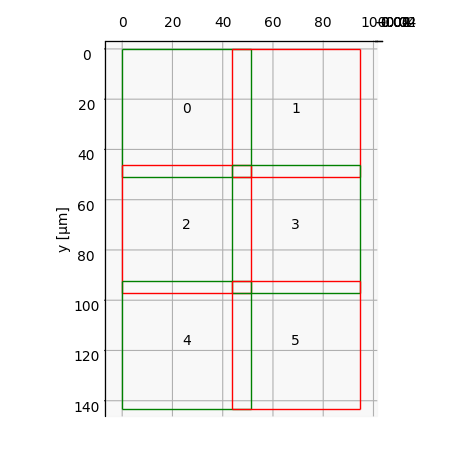

In [8]:
# visualize tile positions/configuration

# uncomment the following line for 3D interactivity with the plot (requires ipympl to be installed)
# % matplotlib widget

from multiview_stitcher import vis_utils

fig, ax = vis_utils.plot_positions(
    msims,
    use_positional_colors=True, # set to False for faster execution in case of more than 20 tiles/views
    transform_key='affine_metadata'
    )

### Visualize input tiles

#### Using neuroglancer

Neuroglancer is a web-based viewer and doesn't require additional installations.

Key bindings: https://github.com/google/neuroglancer/blob/master/README.md#keyboard-and-mouse-bindings

In [9]:
# # interrupt the notebook cell to stop the viewer
# vis_utils.view_neuroglancer(
#     sims=[msi_utils.get_sim_from_msim(msim) for msim in msims],
#     ome_zarr_paths=zarr_paths,
#     transform_key=io.METADATA_TRANSFORM_KEY,
# )

#### Using napari

Requires installing `napari-stitcher` separately.

In [10]:
# # Using napari

# ch_coord = 0 # None if all should be shown

# viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))
# lds = viewer_utils.create_image_layer_tuples_from_msims(
#     msims, ch_coord=ch_coord, transform_key='affine_metadata', n_colors=2, contrast_limits=[0, 500])
# viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)
# viewer.reset_view()

### Align channels (optional)

Perform channel alignment prior to view/tile registration to account for shifts between channels in the input data.
The example data does not exhibit significant channel shifts, but this might be useful for other datasets.

**Note that aligning channels is optional but this cell needs to be run for the subsequent notebook steps to work.**

In [11]:
# Turn channel alignment on or off
perform_channel_alignment = False

# Channel alignment is performed using a single tile.
# Choose here which tile (index) to use.
channel_alignment_tile_index = 0

curr_transform_key = 'affine_metadata'
if perform_channel_alignment:
    curr_transform_key = 'affine_metadata_ch_reg'

    channels = msims[channel_alignment_tile_index]['scale0/image'].coords['c']

    # select chosen tiles for registration
    msims_ch_reg = [msi_utils.multiscale_sel_coords(msims[5], {'c': ch})
                    for ch in channels]

    with dask.diagnostics.ProgressBar():
        params_c = registration.register(
            msims_ch_reg,
            registration_binning={'y': 4, 'x': 4},
            reg_channel_index=0,
            transform_key='affine_metadata',
            pre_registration_pruning_method=None,
        )

    # assign channel coordinates to obtained parameters
    params_c = xr.concat(params_c, dim='c').assign_coords({'c': channels})

    # set obtained parameters for all tiles
    for msim in msims:
        msi_utils.set_affine_transform(
            msim, params_c, transform_key=curr_transform_key, base_transform_key='affine_metadata')


### Register views

To optimize registration results, you can explore different values for `registration_binning` and `reg_channel_index`.

In [12]:
with dask.diagnostics.ProgressBar():

    params = registration.register(
        msims,
        registration_binning={'y': 1, 'x': 1},
        reg_channel_index=0,
        transform_key=curr_transform_key,
        new_transform_key='affine_registered',
        pre_registration_pruning_method="keep_axis_aligned", # works well for tiles on a grid
    )

[########################################] | 100% Completed | 1.05 sms
[########################################] | 100% Completed | 318.79 ms


#### Print the obtained parameters.

How to interpret them?
   - parameters are expressed as homogeneous matrices of dimensions (n+1, n+1)
   - the first n rows and columns correspond to the linear part of the transformation
   - the first three elements of the last column correspond to the translation in (z, y, x)
   - the parameters map the coordinates of the input files (considering their scale and translation) into a world coordinate system in which the tiles are registered


In [13]:
for imsim, msim in enumerate(msims):
    affine = np.array(msi_utils.get_transform_from_msim(msim, transform_key='affine_registered')[0])
    print(f'tile index {imsim}\n', affine)

tile index 0
 [[ 1.          0.          0.65399967]
 [ 0.          1.         -0.15333873]
 [ 0.          0.          1.        ]]
tile index 1
 [[1.         0.         0.67799961]
 [0.         1.         2.58332701]
 [0.         0.         1.        ]]
tile index 2
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tile index 3
 [[1.         0.         0.11199957]
 [0.         1.         2.64999279]
 [0.         0.         1.        ]]
tile index 4
 [[ 1.          0.         -0.24600033]
 [ 0.          1.         -0.0166721 ]
 [ 0.          0.          1.        ]]
tile index 5
 [[ 1.          0.         -0.36200038]
 [ 0.          1.          2.65666038]
 [ 0.          0.          1.        ]]


### Visualize registration

In [14]:
# # Using neuroglancer

# # interrupt the notebook cell to stop the viewer
# vis_utils.view_neuroglancer(
#     sims=[msi_utils.get_sim_from_msim(msim) for msim in msims],
#     ome_zarr_paths=zarr_paths,
#     transform_key='affine_registered',
# )

In [15]:
# # Using napari

# viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

# ch_coord = 0 # None if all should be shown

# lds = viewer_utils.create_image_layer_tuples_from_msims(
#     msims, ch_coord=ch_coord, transform_key='affine_registered', n_colors=2,
#     name_prefix='registered view',
#     contrast_limits=[0, 500],
#     )
# rlayers = viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds, do_link_layers=True)

# viewer.reset_view()

### Fuse views (linear blending)
#### Save output into OME-Zarr

In [16]:
output_dir = download_path
output_filename = os.path.join(output_dir, 'fused.zarr')

fused = fusion.fuse(
    [msi_utils.get_sim_from_msim(msim) for msim in msims],
    transform_key='affine_registered',
    output_chunksize=256,
    )

print(f'Fusing views and saving output to {output_filename}...')
with dask.diagnostics.ProgressBar():
    fused = ngff_utils.write_sim_to_ome_zarr(
        fused, output_filename, overwrite=True
    )


Fusing views and saving output to Stitching_TIFF/fused.zarr...
[########################################] | 100% Completed | 1.08 sms
[########################################] | 100% Completed | 106.77 ms
[########################################] | 100% Completed | 104.79 ms
[########################################] | 100% Completed | 104.58 ms
[########################################] | 100% Completed | 105.15 ms
[########################################] | 100% Completed | 105.60 ms
[########################################] | 100% Completed | 101.74 ms
[########################################] | 100% Completed | 105.67 ms
[########################################] | 100% Completed | 105.74 ms
[########################################] | 100% Completed | 105.92 ms


### Visualize fusion in napari

The output file can also be opened in napari using the napari-ome-zarr plugin.

In [17]:
# viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))

# ch_coord = None

# lds = viewer_utils.create_image_layer_tuples_from_msims(
#     [mfused],
#     ch_coord=ch_coord,
#     transform_key='affine_registered',
#     name_prefix='fused',
#     contrast_limits=[0, 500])

# viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)

### Visualize fusion in neuroglancer

No installation required.

In [18]:
# # interrupt the notebook cell to stop the viewer
# vis_utils.view_neuroglancer(
#     sims=[fused],
#     ome_zarr_paths=[output_filename],
#     channel_coord=0,
#     transform_key="affine_registered",
# )

### Save fused image into tif (optional)

The next cell shows how to save the fused image into a tif file.

However, for large images this will fail and it is recommended to work with OME-Zarr.

In [19]:
output_filename = os.path.join(output_dir, 'fused.tif')

print(f'Streaming into {output_filename}...')
with dask.diagnostics.ProgressBar():
    io.save_sim_as_tif(
        output_filename,
        fused)

Streaming into Stitching_TIFF/fused.tif...
[########################################] | 100% Completed | 105.20 ms


/var/folders/pk/0yb479fx6kxbcw2k8h8tbg7w0000gq/T/ipykernel_41697/1638505360.py:5: UserWarning: Streaming into tif is only supported for zarr < 3(https://github.com/cgohlke/tifffile/issues/272)
  io.save_sim_as_tif(
